# ElMO

Probemos Elmo sólo en inglés a ver qué da...

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
import pandas as pd
import csv
import numpy as np
import tensorflow as tf
import random
import torch

random_seed = 10101119

torch.manual_seed(2*random_seed)
np.random.seed(3*random_seed)
tf.random.set_random_seed(random_seed+1)
random.seed(random_seed/2 + 1)

torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

df_dev = pd.read_table("../../../data/en/dev_en.tsv", index_col="id", quoting=csv.QUOTE_NONE)
df_train = pd.read_table("../../../data/en/train_en.tsv", index_col="id", quoting=csv.QUOTE_NONE)
df_test = pd.read_table("../../../data/en/reference_en.tsv", header=None, 
                        names=["text", "HS", "TR", "AG"], quoting=csv.QUOTE_NONE)


X_train, y_train = df_train["text"], df_train["HS"]
X_dev, y_dev = df_dev["text"], df_dev["HS"]
X_test, y_test = df_test["text"], df_test["HS"]

print("Instancias de entrenamiento: {}".format(len(df_train)))
print("Instancias de desarrollo: {}".format(len(df_dev)))
print("Instancias de test: {}".format(len(df_test)))


Instancias de entrenamiento: 9000
Instancias de desarrollo: 1000
Instancias de test: 2971


In [2]:
from hate.nn.preprocessing import Tokenizer

tokenizer = Tokenizer()

tokens_train = [tokenizer.tokenize(t) for t in X_train]

Using TensorFlow backend.


Hagamos tokenize sobre el texto

(array([ 366., 1747., 1987., 2059., 1170.,  584.,  601.,  373.,   95.,
          18.]),
 array([ 0.,  7., 14., 21., 28., 35., 42., 49., 56., 63., 70.]),
 <a list of 10 Patch objects>)

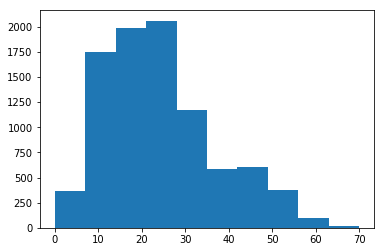

In [3]:
%matplotlib inline
import matplotlib.pyplot as plt

plt.hist([len(t) for t in tokens_train])


In [4]:
%%capture
from elmoformanylangs import Embedder

embedder = Embedder("../../../models/elmo/en/", batch_size=32)

2019-02-21 11:04:27,157 INFO: char embedding size: 4939
2019-02-21 11:04:27,971 INFO: word embedding size: 167642
2019-02-21 11:04:36,824 INFO: Model(
  (token_embedder): ConvTokenEmbedder(
    (word_emb_layer): EmbeddingLayer(
      (embedding): Embedding(167642, 100, padding_idx=3)
    )
    (char_emb_layer): EmbeddingLayer(
      (embedding): Embedding(4939, 50, padding_idx=4936)
    )
    (convolutions): ModuleList(
      (0): Conv1d(50, 32, kernel_size=(1,), stride=(1,))
      (1): Conv1d(50, 32, kernel_size=(2,), stride=(1,))
      (2): Conv1d(50, 64, kernel_size=(3,), stride=(1,))
      (3): Conv1d(50, 128, kernel_size=(4,), stride=(1,))
      (4): Conv1d(50, 256, kernel_size=(5,), stride=(1,))
      (5): Conv1d(50, 512, kernel_size=(6,), stride=(1,))
      (6): Conv1d(50, 1024, kernel_size=(7,), stride=(1,))
    )
    (highways): Highway(
      (_layers): ModuleList(
        (0): Linear(in_features=2048, out_features=4096, bias=True)
        (1): Linear(in_features=2048, out_fe

In [5]:
from keras.optimizers import Adam
from keras.utils import plot_model
from keras.layers import CuDNNLSTM
from hate.nn import CharModel, ElmoModel, BowModel, MergeModel

tokenize_args = {
    'deaccent': False, 
    'language': 'english', 
    'preserve_case': False,
}

elmo_model = ElmoModel(
    max_len=55, embedder=embedder,
    lstm_units=256,
    tokenize_args=tokenize_args,
    dense_units=128,
    recursive_class=CuDNNLSTM, dropout=[0.80, 0.50]
)

Carguemos los hiperparámetros óptimos

In [6]:
from keras.utils import plot_model
from IPython.display import Image

model = elmo_model

print(model.summary())

model.compile(loss='binary_crossentropy',
    optimizer=Adam(lr=0.0005, decay=0.01),
    metrics=['accuracy'])



_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Elmo_Input (InputLayer)      (None, 55, 1024)          0         
_________________________________________________________________
bidirectional_1 (Bidirection (None, 512)               2625536   
_________________________________________________________________
dropout_1 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_elmo (Dense)           (None, 128)               65664     
_________________________________________________________________
dropout_2 (Dropout)          (None, 128)               0         
_________________________________________________________________
output (Dense)               (None, 1)                 129       
Total params: 2,691,329
Trainable params: 2,691,329
Non-trainable params: 0
_________________________________________________________________


In [7]:
from keras.callbacks import ModelCheckpoint, EarlyStopping

checkpointer = ModelCheckpoint('/tmp/en_elmo.h5', save_best_only=True, monitor='val_acc', verbose=1)
early_stopper = EarlyStopping(monitor='val_loss', patience=15)
history = model.fit(X_train, y_train, callbacks=[checkpointer, early_stopper],
          validation_data=(X_dev, y_dev), epochs=300, batch_size=32)


2019-02-21 11:05:05,077 INFO: 282 batches, avg len: 57.0
2019-02-21 11:05:10,637 INFO: Finished 1000 sentences.
2019-02-21 11:05:15,410 INFO: Finished 2000 sentences.
2019-02-21 11:05:20,174 INFO: Finished 3000 sentences.
2019-02-21 11:05:24,966 INFO: Finished 4000 sentences.
2019-02-21 11:05:29,894 INFO: Finished 5000 sentences.
2019-02-21 11:05:34,700 INFO: Finished 6000 sentences.
2019-02-21 11:05:39,623 INFO: Finished 7000 sentences.
2019-02-21 11:05:44,453 INFO: Finished 8000 sentences.
2019-02-21 11:05:49,271 INFO: Finished 9000 sentences.
2019-02-21 11:05:52,786 INFO: 32 batches, avg len: 57.0
2019-02-21 11:05:57,598 INFO: Finished 1000 sentences.


2019-02-21 11:05:58,082 WARNING: Variable *= will be deprecated. Use `var.assign(var * other)` if you want assignment to the variable value or `x = x * y` if you want a new python Tensor object.


Train on 9000 samples, validate on 1000 samples
Epoch 1/300
9000/9000 [==============================] - 8s 840us/step - loss: 0.6880 - acc: 0.5796 - val_loss: 0.6445 - val_acc: 0.6370

Epoch 00001: val_acc improved from -inf to 0.63700, saving model to /tmp/en_elmo.h5
Epoch 2/300
9000/9000 [==============================] - 6s 635us/step - loss: 0.6083 - acc: 0.6618 - val_loss: 0.6058 - val_acc: 0.6850

Epoch 00002: val_acc improved from 0.63700 to 0.68500, saving model to /tmp/en_elmo.h5
Epoch 3/300
9000/9000 [==============================] - 6s 634us/step - loss: 0.5813 - acc: 0.6996 - val_loss: 0.6195 - val_acc: 0.6340

Epoch 00003: val_acc did not improve from 0.68500
Epoch 4/300
9000/9000 [==============================] - 6s 633us/step - loss: 0.5623 - acc: 0.7148 - val_loss: 0.5942 - val_acc: 0.6730

Epoch 00004: val_acc did not improve from 0.68500
Epoch 5/300
9000/9000 [==============================] - 6s 635us/step - loss: 0.5500 - acc: 0.7270 - val_loss: 0.5855 - val_acc:

In [8]:
from hate.utils import print_evaluation

model.load_weights(checkpointer.filepath)
model.preprocess_fit(X_train)

print_evaluation(model, X_dev, y_dev)

print("\n\nEvaluación sobre test")
print_evaluation(model, X_test, y_test)


2019-02-21 11:09:18,037 INFO: 32 batches, avg len: 57.0
2019-02-21 11:09:22,950 INFO: Finished 1000 sentences.


1000/1000 [==============================] - 0s 269us/step


2019-02-21 11:09:25,941 INFO: 32 batches, avg len: 57.0
2019-02-21 11:09:30,883 INFO: Finished 1000 sentences.


Loss           : 0.5719
Accuracy       : 0.7050
Precision(1)   : 0.6585
Precision(1)   : 0.7339
Precision(avg) : 0.6962

Recall(1)      : 0.6323
Recall(0)      : 0.7557
Recall(avg)    : 0.6940

F1(1)          : 0.6452
F1(0)          : 0.7446
F1(avg)        : 0.6949


Evaluación sobre test


2019-02-21 11:09:38,680 INFO: 93 batches, avg len: 57.0
2019-02-21 11:09:43,766 INFO: Finished 1000 sentences.
2019-02-21 11:09:48,747 INFO: Finished 2000 sentences.


2971/2971 [==============================] - 1s 248us/step


2019-02-21 11:10:02,092 INFO: 93 batches, avg len: 57.0
2019-02-21 11:10:06,968 INFO: Finished 1000 sentences.
2019-02-21 11:10:11,678 INFO: Finished 2000 sentences.


Loss           : 0.7359
Accuracy       : 0.5079
Precision(1)   : 0.4546
Precision(1)   : 0.7364
Precision(avg) : 0.5955

Recall(1)      : 0.8914
Recall(0)      : 0.2211
Recall(avg)    : 0.5562

F1(1)          : 0.6021
F1(0)          : 0.3400
F1(avg)        : 0.4711


## Submission


In [11]:
df_test["preds"] = (model.predict(df_test["text"]) >= 0.5).astype(int)
df_dev["preds"] = (model.predict(df_dev["text"]) >= 0.5).astype(int)

2019-01-20 19:50:26,265 INFO: 94 batches, avg len: 57.0
2019-01-20 19:50:31,359 INFO: Finished 1000 sentences.
2019-01-20 19:50:36,542 INFO: Finished 2000 sentences.
2019-01-20 19:50:41,721 INFO: Finished 3000 sentences.
2019-01-20 19:50:47,136 INFO: 32 batches, avg len: 57.0
2019-01-20 19:50:52,196 INFO: Finished 1000 sentences.


In [16]:
!rm en_a.tsv

rm: cannot remove 'en_a.tsv': No such file or directory


In [17]:

with open('en_a.tsv', 'w') as f:
    for i, row in df_test.iterrows():
        f.write('{}\t{}\n'.format(i, row["preds"]))


In [18]:
!cp en_a.tsv ../../../submissions/17_en_ensemble.tsv 

In [19]:
import zipfile

with zipfile.ZipFile("en_a.tsv.zip", 'w') as f:
    f.write('en_a.tsv')
